In [1]:
import pandas as pd
import numpy as np
import annoy
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras
from keras.layers import Dense, Dropout, Flatten
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Reshape,UpSampling2D,Input,Lambda,Conv2DTranspose


# Importing Data

In [3]:
transactions=pd.read_csv('E:/H and M/HM Personal_Laptop/transactions_train.csv')
print(transactions.shape)

(31788324, 5)


In [4]:
articles=pd.read_csv('E:/H and M/HM Personal_Laptop/articles.csv')
print(articles.shape)

(105542, 25)


In [7]:
article_data=pd.read_csv('E:/H and M/HM Personal_Laptop/img_pres.csv')
article_data.drop('Unnamed: 0',axis=1,inplace=True)
article_data.head()

,0
0,0108775015.jpg
1,0108775044.jpg
2,0108775051.jpg
3,0110065001.jpg
4,0110065002.jpg


In [40]:
images=pd.read_csv('image_info.csv')
images.drop('Unnamed: 0',axis=1,inplace=True)

In [45]:
article_data['path']=images.path

In [47]:
article_data

,0,path
0,0108775015.jpg,E:/H and M/HM Personal_Laptop/images/010/01087...
1,0108775044.jpg,E:/H and M/HM Personal_Laptop/images/010/01087...
2,0108775051.jpg,E:/H and M/HM Personal_Laptop/images/010/01087...
3,0110065001.jpg,E:/H and M/HM Personal_Laptop/images/011/01100...
4,0110065002.jpg,E:/H and M/HM Personal_Laptop/images/011/01100...
...,...,...
105095,0953450001.jpg,E:/H and M/HM Personal_Laptop/images/095/09534...
105096,0953763001.jpg,E:/H and M/HM Personal_Laptop/images/095/09537...
105097,0956217002.jpg,E:/H and M/HM Personal_Laptop/images/095/09562...
105098,0957375001.jpg,E:/H and M/HM Personal_Laptop/images/095/09573...


In [8]:
ids=articles.article_id

In [9]:
ids=ids[0:5000]

In [10]:
print(len(ids))

5000


In [11]:
articles=articles.loc[articles['article_id'].isin(ids)][['article_id','product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']]
articles.shape

(5000, 25)

In [12]:
transactions.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [13]:
transactions=transactions.loc[transactions['article_id'].isin(ids)][['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']]
transactions.shape

(2076159, 5)

In [14]:
test_data = transactions.groupby(by="customer_id")['article_id'].agg(list).reset_index()
test_data.head(25)

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[176209023]
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[351484002, 478646001, 351484002, 377277001, 3..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[351484002, 351484002]"
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[399061015, 399061015]"
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,[448509014]
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[349301001, 464454004, 272591001, 413707001, 3..."
6,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,"[308154005, 400456001, 453239043, 485552003]"
7,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[407354008, 347200001]"
8,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[373506019, 478298005, 403392002, 253448002, 3..."
9,0000f2ea26b7f0a9175f428c8cf7743e9e10e193465ecd...,"[436083003, 436083003]"


In [27]:
test_data.iloc[5,0]

'00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2'

In [16]:
embeds=pd.read_csv('similarities_image.csv')
print(embeds.shape)
embeds.head()

(5000, 5001)


,path,E:/H and M/HM Personal_Laptop/images/010/0108775015.jpg,E:/H and M/HM Personal_Laptop/images/010/0108775044.jpg,E:/H and M/HM Personal_Laptop/images/010/0108775051.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065001.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065002.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065011.jpg,E:/H and M/HM Personal_Laptop/images/011/0111565001.jpg,E:/H and M/HM Personal_Laptop/images/011/0111565003.jpg,E:/H and M/HM Personal_Laptop/images/011/0111586001.jpg,...,E:/H and M/HM Personal_Laptop/images/048/0489217007.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435001.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435002.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435009.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435010.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435011.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435012.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435014.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435015.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435016.jpg
0,E:/H and M/HM Personal_Laptop/images/010/01087...,1.000000,0.961681,0.974386,0.977738,0.961188,0.972273,0.941894,0.957899,0.956268,...,0.911624,0.951709,0.951384,0.954769,0.954861,0.950637,0.955816,0.947313,0.954170,0.945386
1,E:/H and M/HM Personal_Laptop/images/010/01087...,0.961681,1.000000,0.978197,0.958795,0.993788,0.981855,0.962285,0.958465,0.963825,...,0.918834,0.980947,0.973577,0.976915,0.974529,0.977722,0.975748,0.953639,0.976721,0.961853
2,E:/H and M/HM Personal_Laptop/images/010/01087...,0.974386,0.978197,1.000000,0.965839,0.975869,0.977835,0.948924,0.966358,0.962569,...,0.924103,0.970994,0.963249,0.966562,0.967037,0.969613,0.966992,0.957639,0.967525,0.961195
3,E:/H and M/HM Personal_Laptop/images/011/01100...,0.977738,0.958795,0.965839,1.000000,0.966312,0.983325,0.943709,0.943825,0.946089,...,0.913624,0.958085,0.963144,0.962034,0.963686,0.957867,0.963485,0.949646,0.962482,0.949798
4,E:/H and M/HM Personal_Laptop/images/011/01100...,0.961188,0.993788,0.975869,0.966312,1.000000,0.988004,0.962125,0.951366,0.954847,...,0.913356,0.986873,0.980306,0.981371,0.980496,0.983150,0.981786,0.955436,0.981588,0.965257


In [17]:
embeds.set_index('path',inplace=True)

In [18]:
embeds.head()

,E:/H and M/HM Personal_Laptop/images/010/0108775015.jpg,E:/H and M/HM Personal_Laptop/images/010/0108775044.jpg,E:/H and M/HM Personal_Laptop/images/010/0108775051.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065001.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065002.jpg,E:/H and M/HM Personal_Laptop/images/011/0110065011.jpg,E:/H and M/HM Personal_Laptop/images/011/0111565001.jpg,E:/H and M/HM Personal_Laptop/images/011/0111565003.jpg,E:/H and M/HM Personal_Laptop/images/011/0111586001.jpg,E:/H and M/HM Personal_Laptop/images/011/0111593001.jpg,...,E:/H and M/HM Personal_Laptop/images/048/0489217007.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435001.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435002.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435009.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435010.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435011.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435012.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435014.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435015.jpg,E:/H and M/HM Personal_Laptop/images/048/0489435016.jpg
path,,,,,,,,,,,,,,,,,,,,,
E:/H and M/HM Personal_Laptop/images/010/0108775015.jpg,1.000000,0.961681,0.974386,0.977738,0.961188,0.972273,0.941894,0.957899,0.956268,0.958372,...,0.911624,0.951709,0.951384,0.954769,0.954861,0.950637,0.955816,0.947313,0.954170,0.945386
E:/H and M/HM Personal_Laptop/images/010/0108775044.jpg,0.961681,1.000000,0.978197,0.958795,0.993788,0.981855,0.962285,0.958465,0.963825,0.964833,...,0.918834,0.980947,0.973577,0.976915,0.974529,0.977722,0.975748,0.953639,0.976721,0.961853
E:/H and M/HM Personal_Laptop/images/010/0108775051.jpg,0.974386,0.978197,1.000000,0.965839,0.975869,0.977835,0.948924,0.966358,0.962569,0.964599,...,0.924103,0.970994,0.963249,0.966562,0.967037,0.969613,0.966992,0.957639,0.967525,0.961195
E:/H and M/HM Personal_Laptop/images/011/0110065001.jpg,0.977738,0.958795,0.965839,1.000000,0.966312,0.983325,0.943709,0.943825,0.946089,0.949469,...,0.913624,0.958085,0.963144,0.962034,0.963686,0.957867,0.963485,0.949646,0.962482,0.949798
E:/H and M/HM Personal_Laptop/images/011/0110065002.jpg,0.961188,0.993788,0.975869,0.966312,1.000000,0.988004,0.962125,0.951366,0.954847,0.958376,...,0.913356,0.986873,0.980306,0.981371,0.980496,0.983150,0.981786,0.955436,0.981588,0.965257


In [73]:
embeds.iloc[-1]

../input/h-and-m-personalized-fashion-recommendations/images/010/0108775044.jpg    0.954906
../input/h-and-m-personalized-fashion-recommendations/images/010/0108775051.jpg    0.954079
../input/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg    0.943157
../input/h-and-m-personalized-fashion-recommendations/images/011/0111565001.jpg    0.948443
../input/h-and-m-personalized-fashion-recommendations/images/011/0118458038.jpg    0.956325
                                                                                     ...   
../input/h-and-m-personalized-fashion-recommendations/images/048/0482638017.jpg    0.925346
../input/h-and-m-personalized-fashion-recommendations/images/048/0483737006.jpg    0.956764
../input/h-and-m-personalized-fashion-recommendations/images/048/0483283022.jpg    0.936922
../input/h-and-m-personalized-fashion-recommendations/images/048/0488016013.jpg    0.944554
../input/h-and-m-personalized-fashion-recommendations/images/048/0488555002.jpg 

In [48]:
def retrieve_most_similar_products(idd):
    a=articles[articles['article_id']==idd].index.values.astype('int')
    print(idd,articles.loc[a,'product_type_name'])
    a='0'+str(idd)+'.jpg'
    b=article_data[article_data['0']==a].index.values.astype('int')
    print(a,b)
    given_img=article_data.loc[article_data['0']==a]['path'].item()
    original = load_img(given_img)
    plt.imshow(original)
    plt.show()
    print("most similar products:")

    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    closest_imgs_scores = embeds[given_img].sort_values(ascending=False)[1:5+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i],target_size=(224,224))
        s1=slice(66,76)
        target=closest_imgs[i][s1]
        plt.imshow(original)
        plt.show()
        print("similar article: ",target)
    

108775044 1    Vest top
Name: product_type_name, dtype: object
0108775044.jpg [1]


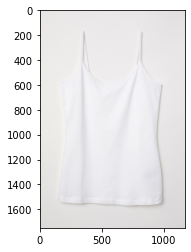

most similar products:


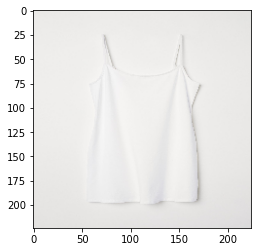

similar article:  


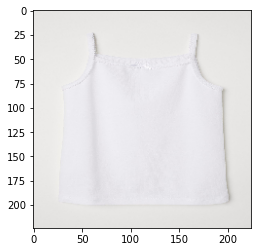

similar article:  


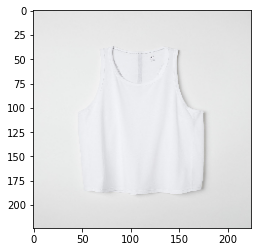

similar article:  


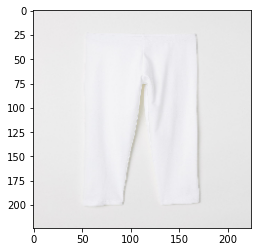

similar article:  


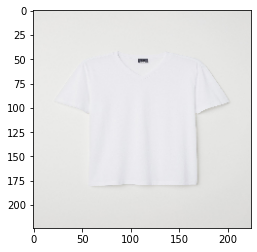

similar article:  


In [49]:
retrieve_most_similar_products(108775044)

[349301001, 464454004, 272591001, 413707001, 351933001, 478549001, 444325004, 425217006, 312878001, 312878010, 312878010, 349301041, 160442010, 372860001, 160442007, 304786008]
[349301001, 464454004, 272591001, 413707001, 351933001, 478549001, 444325004, 425217006, 312878001, 312878010, 312878010, 349301041, 160442010, 372860001, 160442007, 304786008]
          products                        article_ids
0       Ballerinas             [349301001, 349301041]
1              Bra                        [351933001]
2             Coat  [312878001, 312878010, 312878010]
3            Dress             [272591001, 444325004]
4  Leggings/Tights                        [413707001]
['349301001', '351933001', '312878001', '272591001', '413707001', '425217006', '464454004', '160442010', '478549001']
349301001 Series([], Name: product_type_name, dtype: object)
0349301001.jpg [1412]


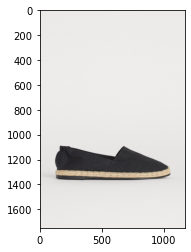

most similar products:


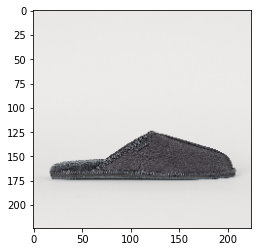

similar article:  


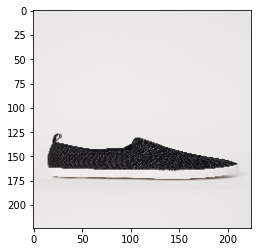

similar article:  


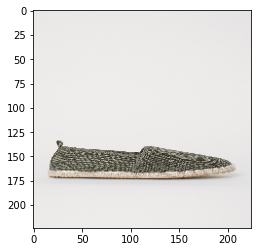

similar article:  


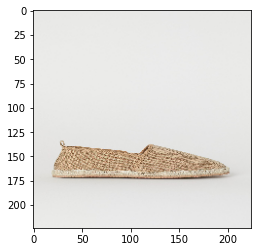

similar article:  


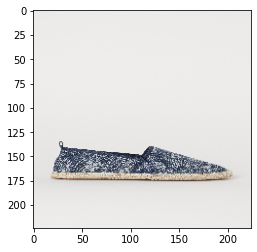

similar article:  
351933001 Series([], Name: product_type_name, dtype: object)
0351933001.jpg [1474]


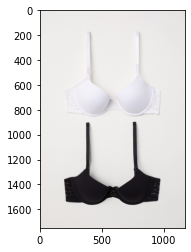

most similar products:


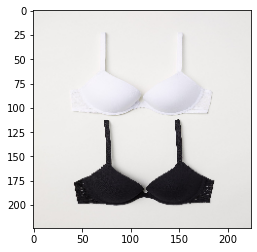

similar article:  


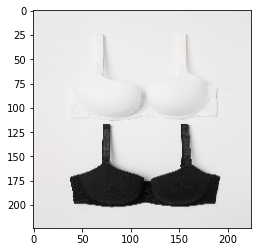

similar article:  


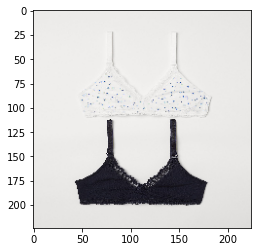

similar article:  


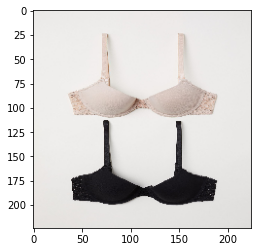

similar article:  


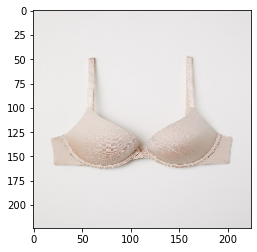

similar article:  
312878001 Series([], Name: product_type_name, dtype: object)
0312878001.jpg [1031]


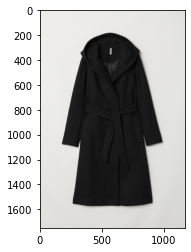

most similar products:


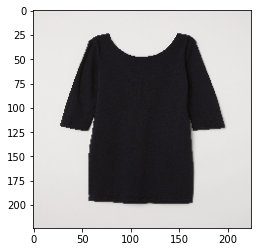

similar article:  


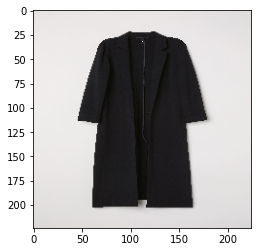

similar article:  


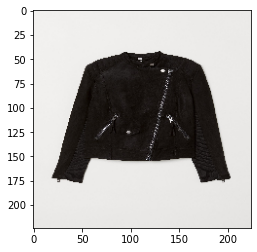

similar article:  


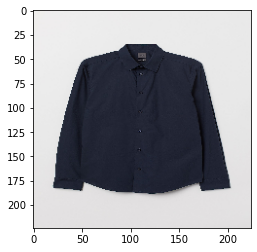

similar article:  


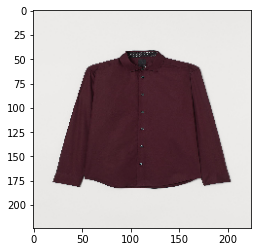

similar article:  
272591001 Series([], Name: product_type_name, dtype: object)
0272591001.jpg []
iamge not there
413707001 Series([], Name: product_type_name, dtype: object)
0413707001.jpg [2520]


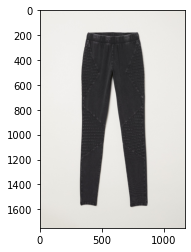

most similar products:


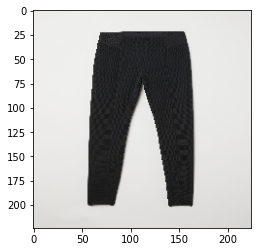

similar article:  


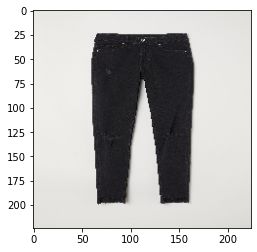

similar article:  


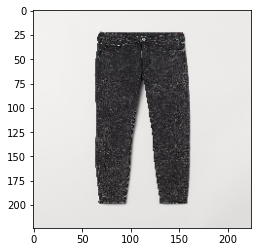

similar article:  


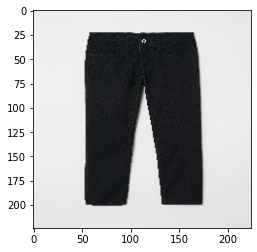

similar article:  


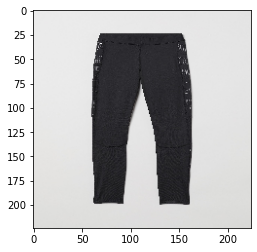

similar article:  
425217006 Series([], Name: product_type_name, dtype: object)
0425217006.jpg [2687]


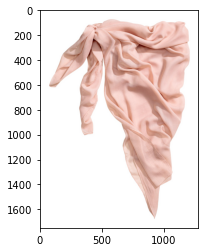

most similar products:


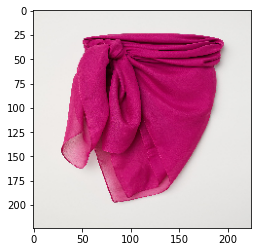

similar article:  


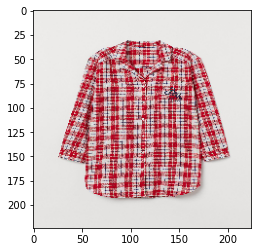

similar article:  


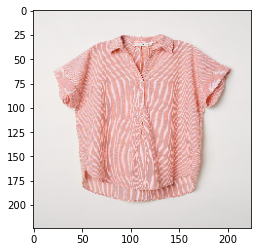

similar article:  


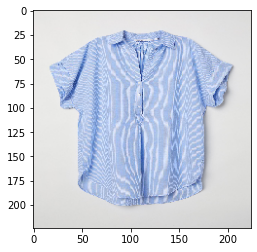

similar article:  


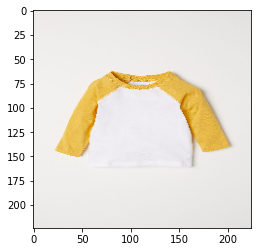

similar article:  
464454004 Series([], Name: product_type_name, dtype: object)
0464454004.jpg [3680]


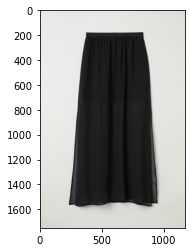

most similar products:


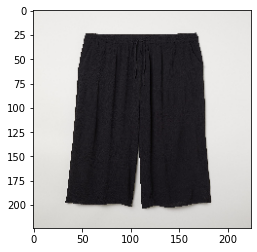

similar article:  


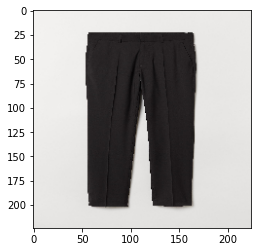

similar article:  


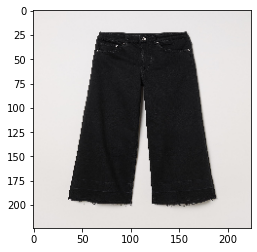

similar article:  


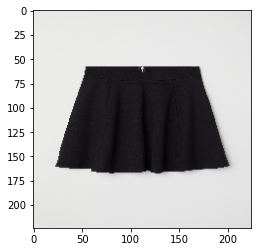

similar article:  


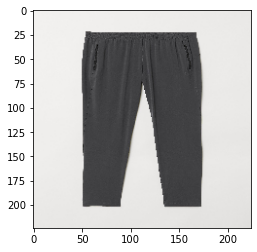

similar article:  
160442010 Series([], Name: product_type_name, dtype: object)
0160442010.jpg [75]


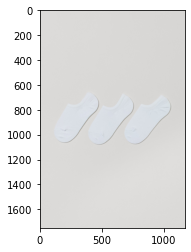

most similar products:


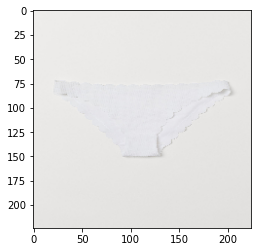

similar article:  


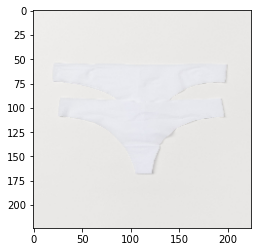

similar article:  


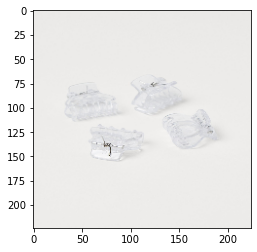

similar article:  


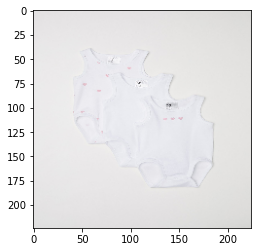

similar article:  


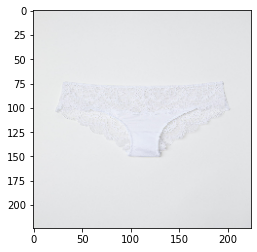

similar article:  
478549001 Series([], Name: product_type_name, dtype: object)
0478549001.jpg [4118]


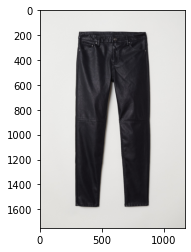

most similar products:


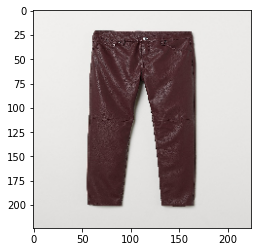

similar article:  


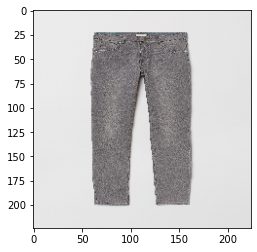

similar article:  


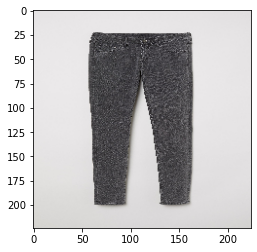

similar article:  


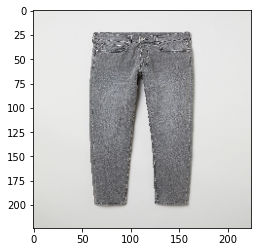

similar article:  


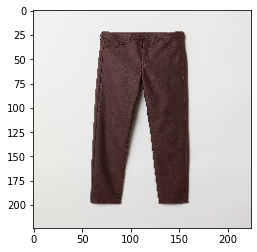

similar article:  


In [50]:
cust_id='00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2'
index_pos=test_data[test_data['customer_id']==cust_id].index.values
arts=test_data.iloc[index_pos[0],1]
print(arts)
products=[]
items=[]
for a in arts:
    art_index=articles[articles.article_id==a].index.values
    products.append(articles.at[art_index[0],'product_type_name'])
    items.append(a)
print(items)
unique_items=pd.DataFrame()
unique_items['products']=pd.Series(products)
unique_items['article_ids']=pd.Series(items)
unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
print(unique_products.head())
final_list=[]
for i,j in zip(unique_products['products'],unique_products['article_ids']):
    arts_list=[]
    for x in j:
        arts_list.append(str(x))
    final_list.append(arts_list[0])
print(final_list)
for ids in final_list:
    idd = ids
    try:
        retrieve_most_similar_products(idd)
    except:
        print('iamge not there')
    